# CIECAM02 - Unity

In [1]:
from __future__ import division

import IPython.display
import PIL.Image
import matplotlib

matplotlib.use('agg')

import matplotlib.pyplot
import numpy as np
import os
import scipy.optimize
import subprocess

from cStringIO import StringIO
    
import colour
import colour_hdri
from colour.plotting import *

colour.filter_warnings(True, False)

np.set_printoptions(formatter={'float': '{: 0.15f}'.format})

//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Helpers & Resources

In [2]:
def array_plot(a, fmt='png'):
    buffer = StringIO()

    PIL.Image.fromarray(a).save(buffer, fmt)
    IPython.display.display(IPython.display.Image(data=buffer.getvalue()))
    

def RMSE(a, b):
    return np.sqrt(((a - b) ** 2).mean())

## CIECAM02 - Predictions

In [3]:
SURROUND = 'Dim'


def auto_crop_array(a, keyer, threshold=0.01):
    a_c = np.copy(a).astype(np.float_)

    mask = np.abs(a - np.array([keyer, keyer, keyer])).sum(axis=2) < threshold

    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    return a[top_left[0]:bottom_right[0],
             top_left[1]:bottom_right[1]]


def lateral_brightness_adaptation(samples, background_colour):
    cp_1 = ColourParameter(RGB=samples[0])
    cp_2 = ColourParameter(RGB=samples[1])
    cp_3 = ColourParameter(RGB=samples[2])

    matplotlib.pyplot.clf()
    padding = 1
    figure = multi_colour_plot(
        [cp_1, cp_2, cp_3],
        height=2,
        spacing=padding,
        margins=(-padding, padding, -padding * 4, padding),
        background_colour=background_colour,
        standalone=False)

    for location in ('top', 'right', 'bottom', 'left'):
        figure.gca().spines[location].set_visible(False)
    figure.canvas.draw()

    lba = np.fromstring(figure.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    lba = lba.reshape(figure.canvas.get_width_height()[::-1] + (3,))
    lba = auto_crop_array(lba, 191)
    
    return lba


def lateral_brightness_adaptation_plot(samples):
    b_l = colour.oetf_sRGB(0.01)
    b_h = colour.oetf_sRGB(0.99)
    lba_w = lateral_brightness_adaptation(samples, (b_h, b_h, b_h))
    lba_r = lateral_brightness_adaptation(samples, (b_l, b_l, b_l))

    array_plot(colour.orient(colour.orient(
                np.vstack((colour.orient(lba_w, 'Flop'), lba_r)), '90 CW'), 'Flop'))

    XYZ = colour.sRGB_to_XYZ(samples, apply_decoding_cctf=True) * 100

    XYZ_w = np.array([95.05, 100.00, 108.88])
    L_A = 4
    Y_b = b_l * 100
    surround = colour.CIECAM02_VIEWING_CONDITIONS[SURROUND]
    CIECAM02_s = colour.XYZ_to_CIECAM02(
        XYZ, XYZ_w, L_A, Y_b, surround, discount_illuminant=True)

    Y_b = b_h * 100
    XYZ_p = colour.CIECAM02_to_XYZ(
        CIECAM02_s.J,
        CIECAM02_s.C,
        CIECAM02_s.h,
        XYZ_w, L_A, Y_b, surround, discount_illuminant=True)
    samples = np.clip(colour.XYZ_to_sRGB(XYZ_p / 100, apply_encoding_cctf=True), 0, 1)

    lba_p = lateral_brightness_adaptation(samples, (b_h, b_h, b_h))

    array_plot(colour.orient(colour.orient(
                np.vstack((colour.orient(lba_p, 'Flop'), lba_r)), '90 CW'), 'Flop'))

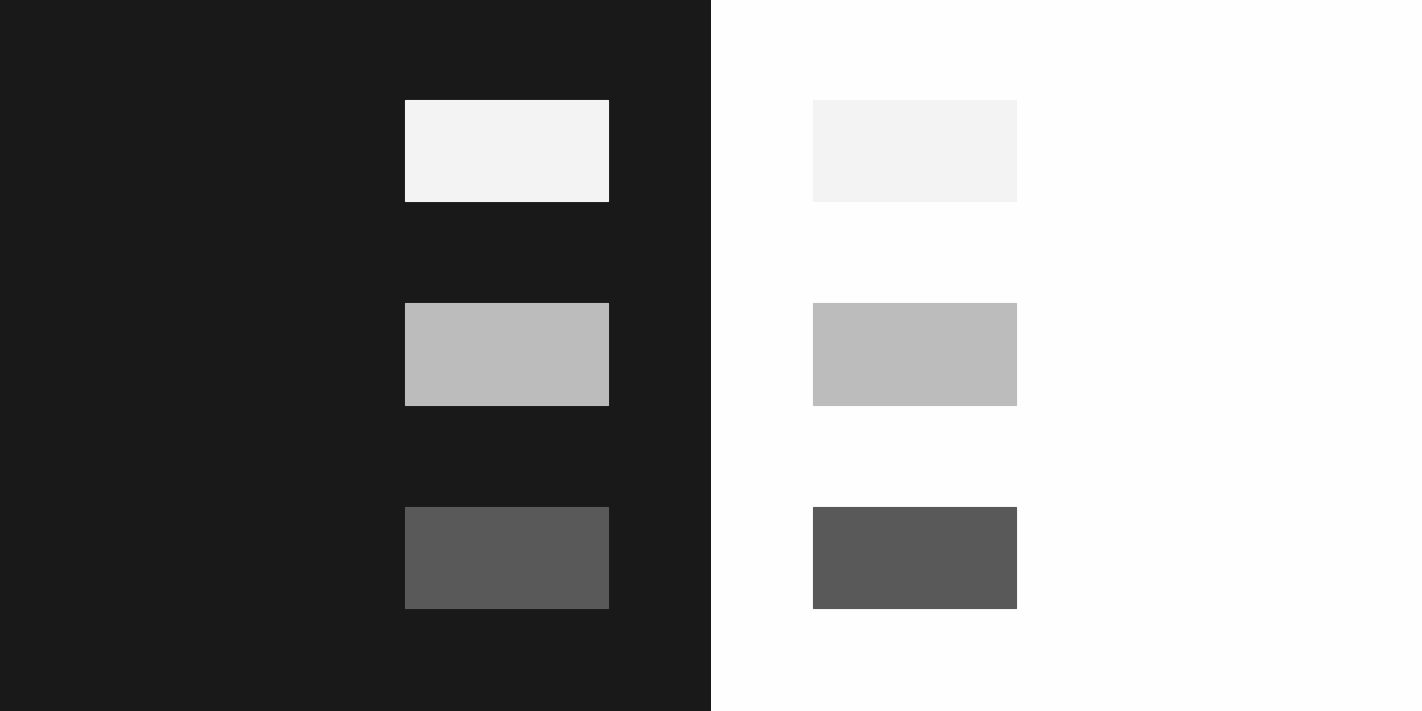

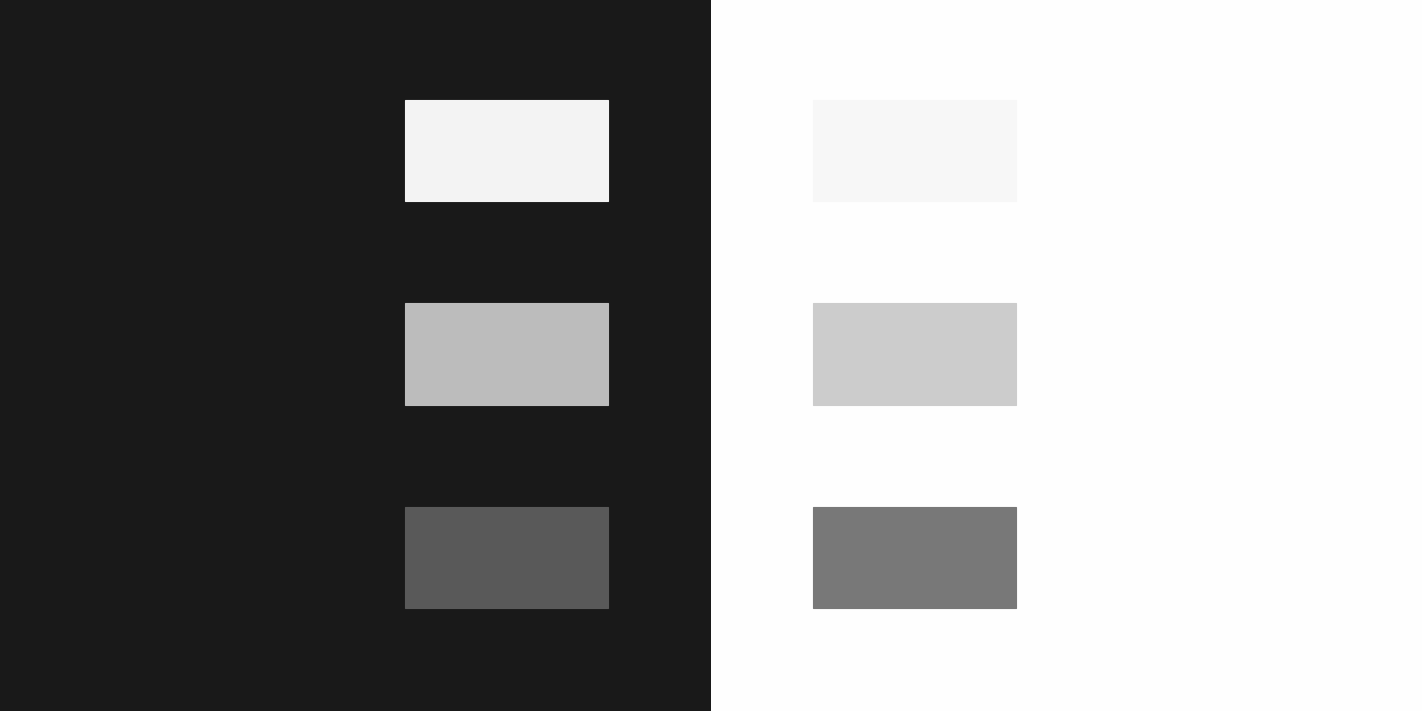

In [4]:
samples_c = 11
samples = colour.oetf_sRGB(np.linspace(0, 1, samples_c))
i_1, i_2, i_3 = 1, int(samples_c / 2), -2
samples = np.array([[samples[i_1], samples[i_1], samples[i_1]], 
                    [samples[i_2], samples[i_2], samples[i_2]],
                    [samples[i_3], samples[i_3], samples[i_3]]])

lateral_brightness_adaptation_plot(samples)

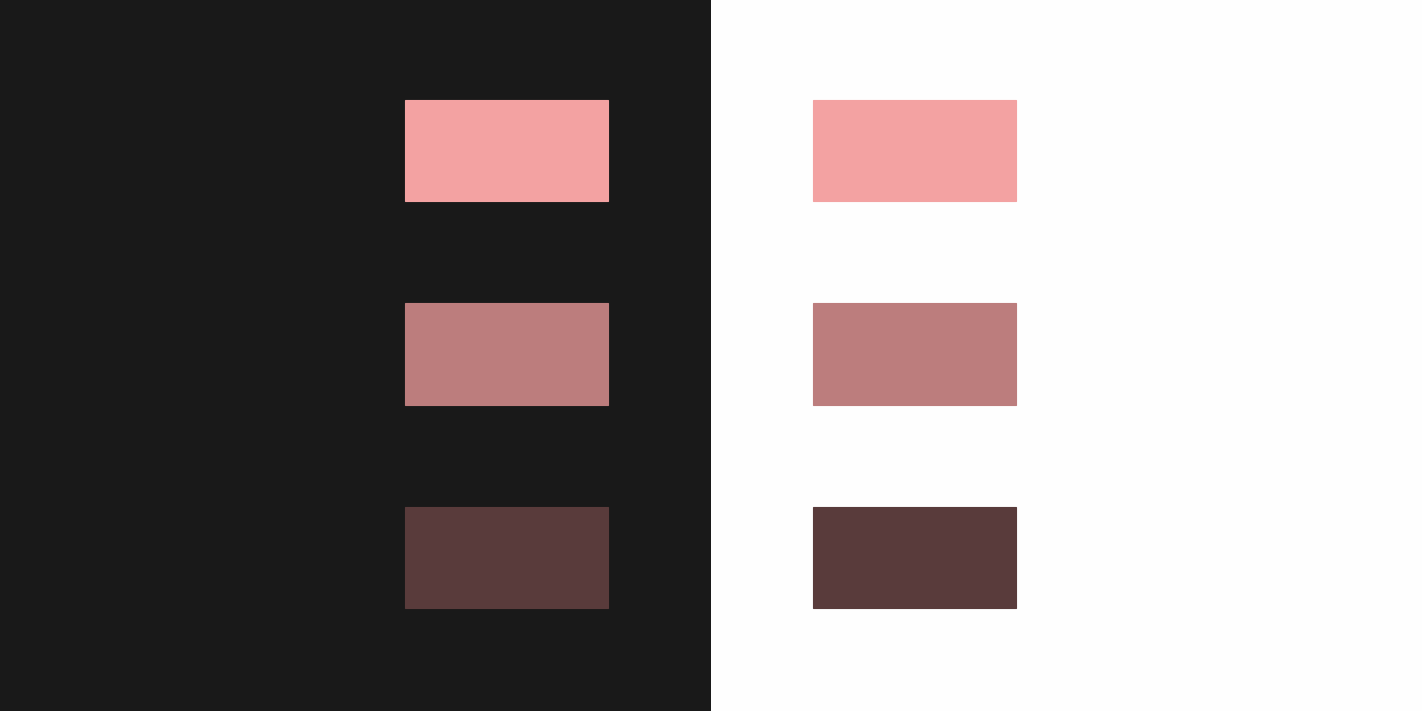

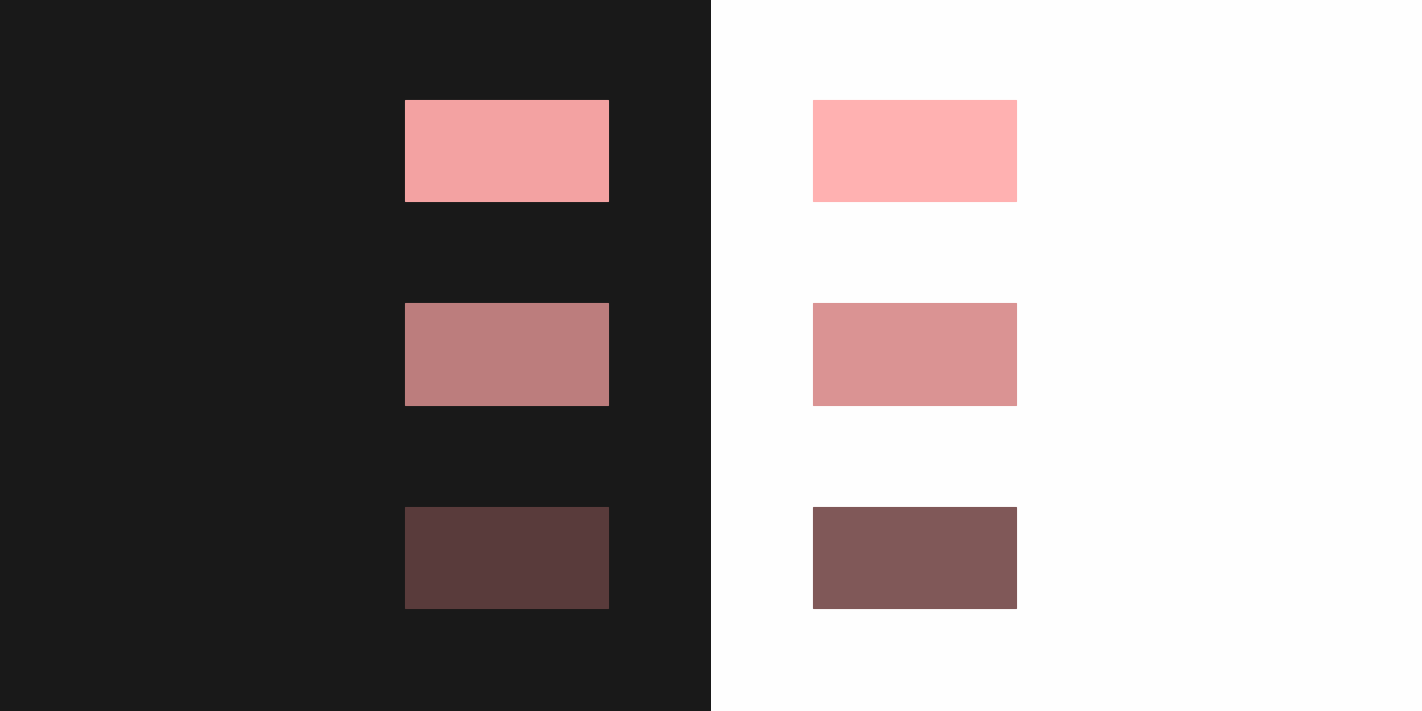

In [5]:
samples_r = np.copy(samples)
samples_r[:, 1:3] /= 1.5

lateral_brightness_adaptation_plot(samples_r)

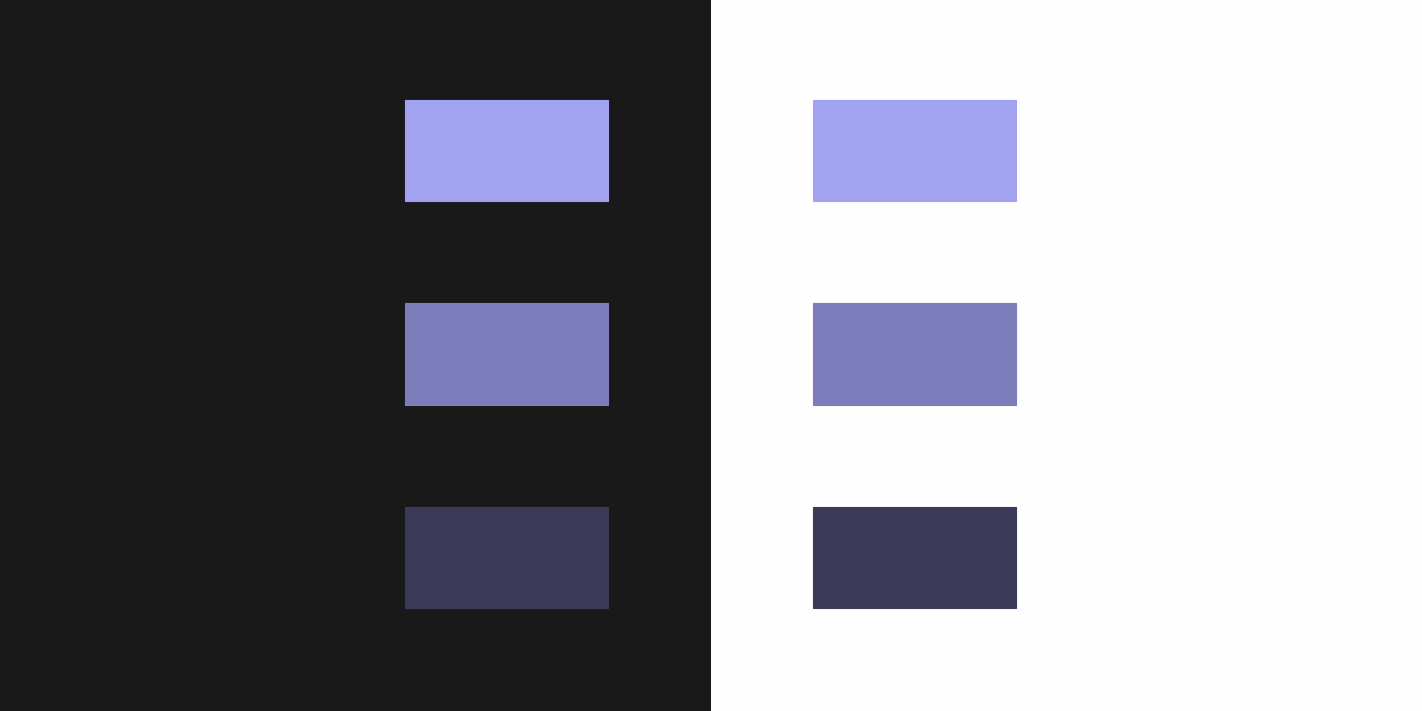

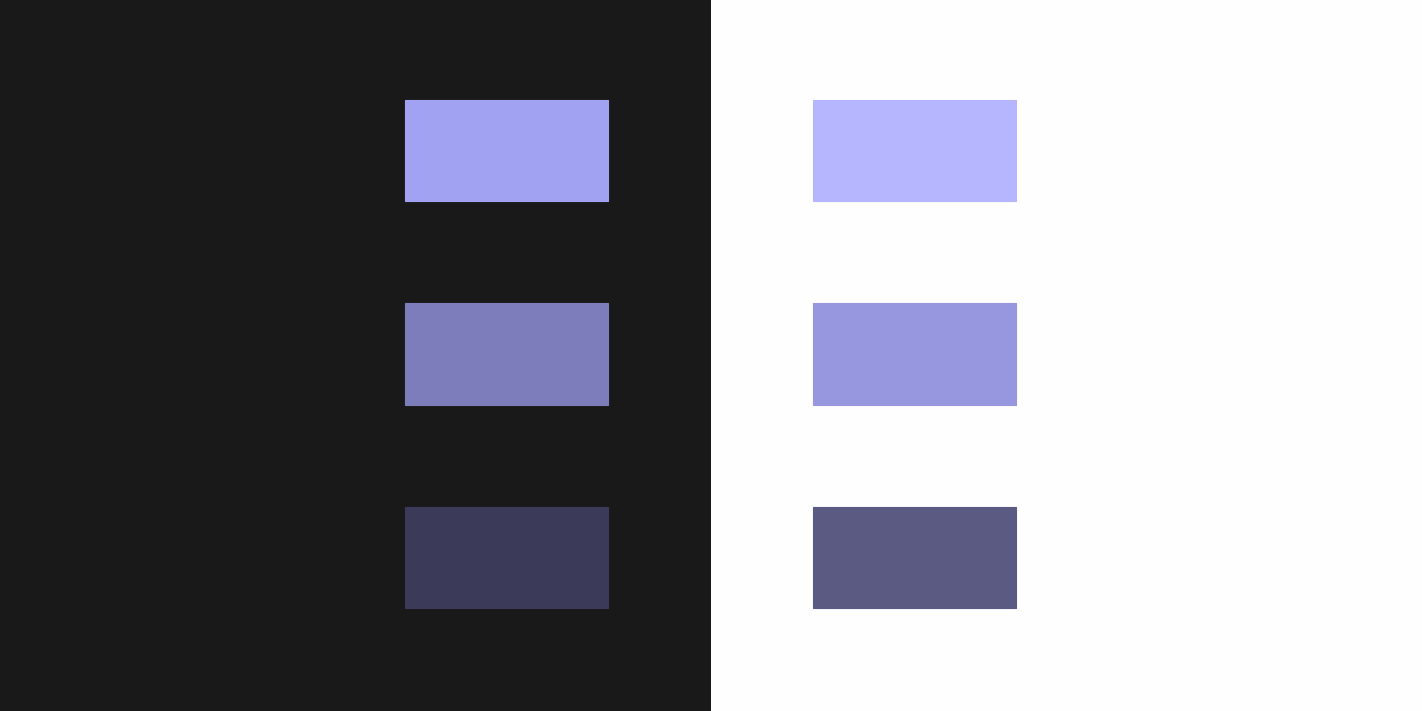

In [6]:
samples_b = np.copy(samples)
samples_b[:, 0:2] /= 1.5

lateral_brightness_adaptation_plot(samples_b)

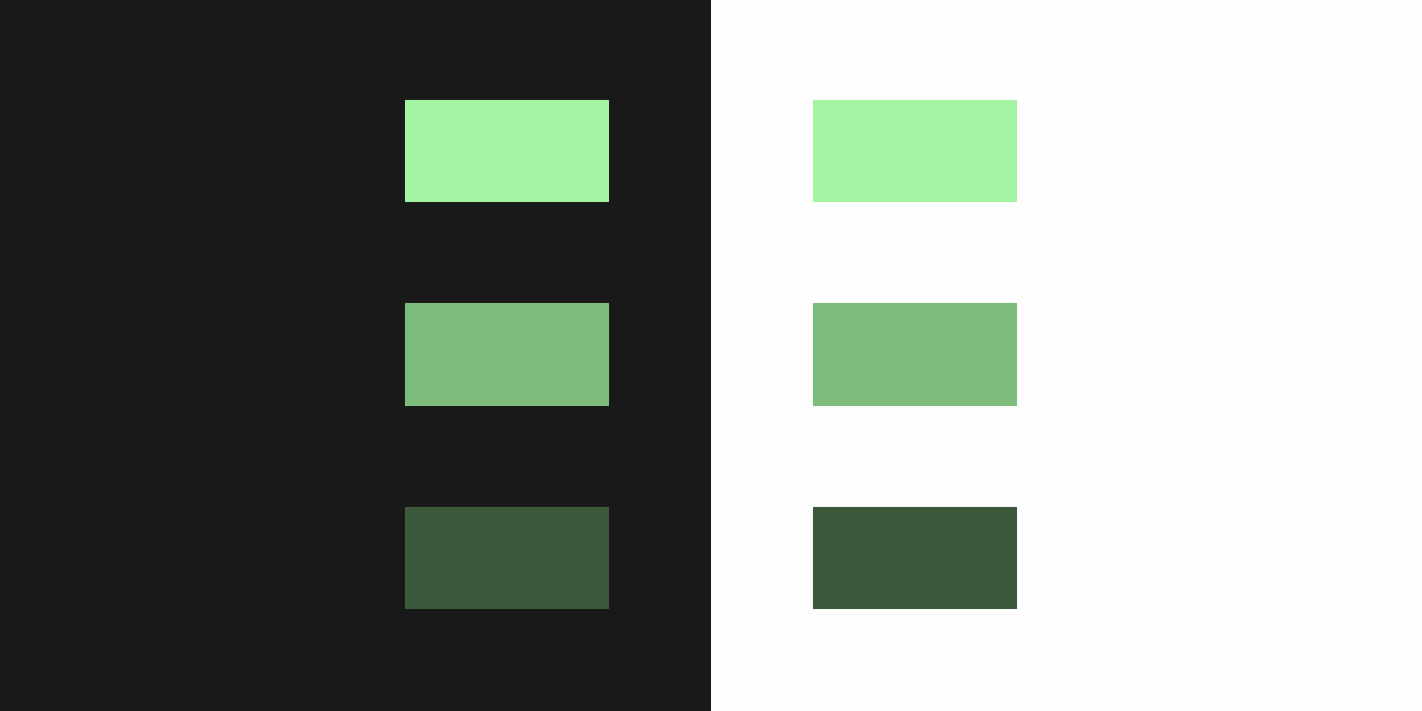

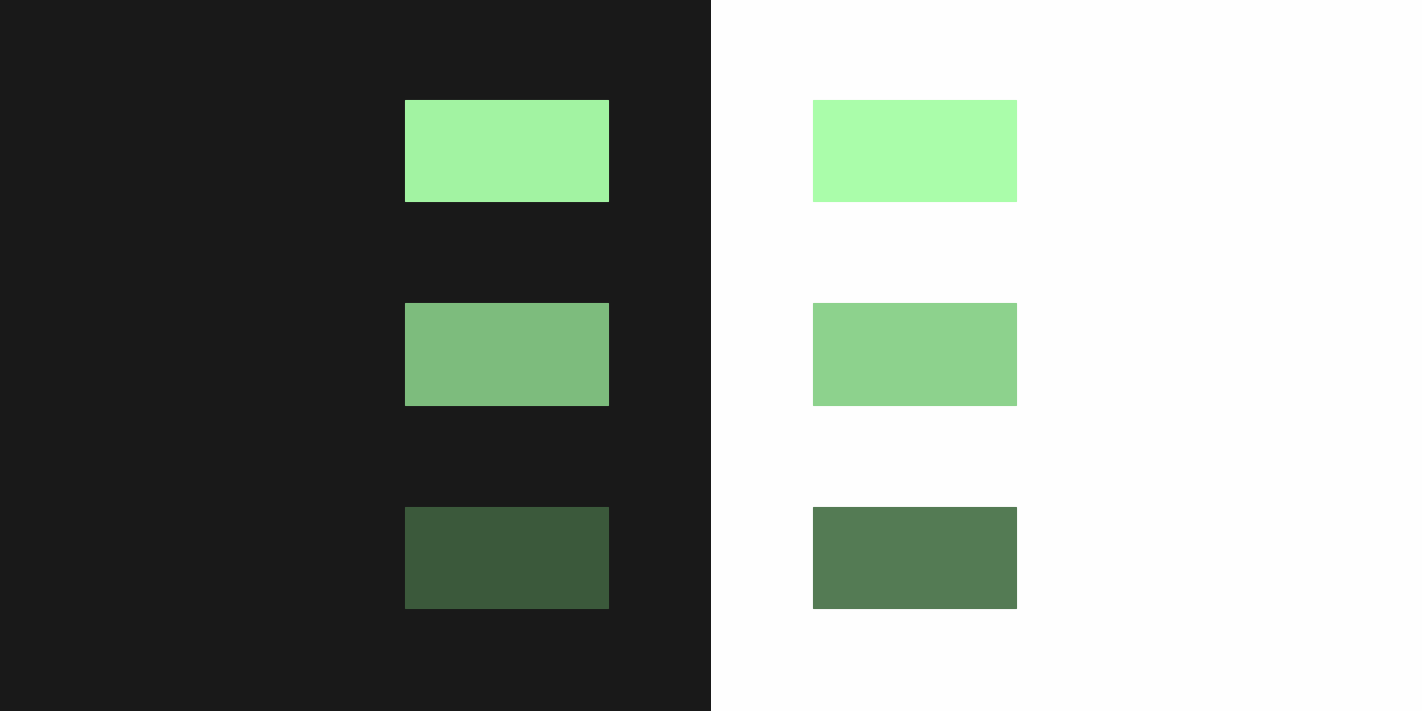

In [7]:
samples_g = np.copy(samples)
samples_g[:, 0] /= 1.5
samples_g[:, 2] /= 1.5

lateral_brightness_adaptation_plot(samples_g)

## ACES

## CTL Initialisation

In [8]:
IO_DIRECTORY = os.path.abspath(
    os.path.join(
        '/Users/kelsolaar/Documents/Development/'
        'colour-science/colour-ramblings/resources/images'))

not os.path.exists(IO_DIRECTORY) and os.makedirs(IO_DIRECTORY)

CTL_ROOT_DIRECTORY = os.path.abspath(
    os.path.join(
        '/Users/kelsolaar/Documents/Development/'
        'colour-science/aces-dev/transforms/ctl'))

os.environ['CTL_MODULE_PATH'] = os.path.join(CTL_ROOT_DIRECTORY, 'lib')

CTL_RENDER = 'ctlrender'
CTL_DEFAULT_ARGUMENTS = ['-verbose', '-force']

In [9]:
def ctl_render(image_i, image_o, ctls, ctl_args=CTL_DEFAULT_ARGUMENTS):
    ctls_arguments = []
    for ctl in ctls:
        ctls_arguments.append('-ctl')
        ctls_arguments.append(ctl)

    output = subprocess.check_output(
        [CTL_RENDER] + ctl_args + [image_i, image_o] + ctls_arguments)
    
    return output

## Helpers & Resources

In [10]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

BOKEH_TOOLS = 'pan,wheel_zoom,box_zoom,reset,resize,hover'

In [11]:
output_notebook()

Loading BokehJS ...

In [12]:
MINIMUM_REPR_NUMBER = 5.96e-08
MAXIMUM_REPR_NUMBER = 65504
MAXIMUM_FIT_NUMBER = 2

DEFAULT_SAMPLE_COUNT = 16384


SAMPLES_LOG = np.logspace(np.log10(MINIMUM_REPR_NUMBER), 
                          np.log10(MAXIMUM_REPR_NUMBER), 
                          DEFAULT_SAMPLE_COUNT)
SAMPLES = np.linspace(SAMPLES_LOG[0], 
                      MAXIMUM_FIT_NUMBER, 
                      DEFAULT_SAMPLE_COUNT / 4)


def write_log_ramp_image(path, in_=0, out=1, samples=DEFAULT_SAMPLE_COUNT):
    a = np.logspace(np.log10(in_), np.log10(out), samples)[np.newaxis, ...]
    a = colour.tstack((a, a, a))
    colour.write_image(a, path)


LOG_RAMP_PATH = os.path.join(IO_DIRECTORY, 'log_ramp.exr')

write_log_ramp_image(LOG_RAMP_PATH, MINIMUM_REPR_NUMBER, MAXIMUM_REPR_NUMBER)

### RRT.a1.0.3 + ODT.Academy.RGBmonitor_100nits_dim.a1.0.3

In [13]:
ODT_RGB_MONITOR_LOG_RAMP_PATH = os.path.join(
    IO_DIRECTORY, 'ODT_rgb_monitor_log_ramp.exr')

ctl_render(LOG_RAMP_PATH, 
           ODT_RGB_MONITOR_LOG_RAMP_PATH,
           (os.path.join(CTL_ROOT_DIRECTORY, 
                         'rrt', 
                         'RRT.ctl'),
            os.path.join(CTL_ROOT_DIRECTORY, 
                         'odt', 
                         'rgbMonitor', 
                         'ODT.Academy.RGBmonitor_100nits_dim.ctl')))

ODT_RGB_MONITOR_LOG_RAMP_IMAGE = colour.read_image(ODT_RGB_MONITOR_LOG_RAMP_PATH)

In [14]:
def curve(x, a, b, c, d, e):
    return (x * (a * x + b)) / (x * (c * x + d) + e)


RRT_ODT_interpolator = colour.LinearInterpolator(
    SAMPLES_LOG, ODT_RGB_MONITOR_LOG_RAMP_IMAGE[..., 0])

plot = figure(tools=BOKEH_TOOLS, 
              x_range=[MINIMUM_REPR_NUMBER * 10e4, MAXIMUM_FIT_NUMBER], 
              x_axis_type='log')
plot.line(SAMPLES, 
          colour.eotf_sRGB(RRT_ODT_interpolator(SAMPLES)), 
          color="red", 
          legend='ODT(RRT)')

# TODO: Check the reason why covariance matrices have such high values.
popt, pcov = scipy.optimize.curve_fit(
    curve, 
    SAMPLES, 
    colour.eotf_sRGB(RRT_ODT_interpolator(SAMPLES)))
plot.line(SAMPLES, 
          curve(SAMPLES, *popt), 
          color="green", 
          legend='ODT(RRT) - Optimisation Fit')

plot.line(SAMPLES, 
          np.abs(colour.eotf_sRGB(RRT_ODT_interpolator(SAMPLES)) - 
                 curve(SAMPLES, *popt)), 
          color="blue", legend='Error')

plot.legend.location = 'top_left'

show(plot)

print(popt)
print('RMSE: {0}'.format(RMSE(
    colour.eotf_sRGB(RRT_ODT_interpolator(SAMPLES)), 
    curve(SAMPLES, *popt))))

[ 278.508452016034312  10.777173236228062  293.604480035671997
  88.712248853759547  80.688937129502875]
RMSE: 0.0012846272106


## RRT.a1.0.3 + ODT.Academy.Rec2020_ST2084_1000nits.a1.0.3

In [15]:
ODT_REC2020_ST2084_1000NITS_LOG_RAMP_PATH = os.path.join(
    IO_DIRECTORY, 'ODT_Rec2020_ST2084_1000nits_log_ramp.exr')

ctl_render(LOG_RAMP_PATH, 
           ODT_REC2020_ST2084_1000NITS_LOG_RAMP_PATH,
           (os.path.join(CTL_ROOT_DIRECTORY, 'rrt', 'RRT.ctl'),
            os.path.join(CTL_ROOT_DIRECTORY, 'odt', 'hdr_st2084', 'ODT.Academy.Rec2020_ST2084_1000nits.ctl'), ))

ODT_REC2020_ST2084_1000NITS_LOG_RAMP_IMAGE = colour.read_image(
    ODT_REC2020_ST2084_1000NITS_LOG_RAMP_PATH)

In [16]:
def curve(x, a, b, c, d, e):
    return (x * (a * x + b)) / (x * (c * x + d) + e)


SAMPLES = np.linspace(SAMPLES_LOG[0], SAMPLES_LOG[-1], DEFAULT_SAMPLE_COUNT / 4)

RRT_ODT_interpolator = colour.LinearInterpolator(
    SAMPLES_LOG, ODT_REC2020_ST2084_1000NITS_LOG_RAMP_IMAGE[..., 0])

plot = figure(tools=BOKEH_TOOLS, 
              x_range=[MINIMUM_REPR_NUMBER * 10e4, MAXIMUM_FIT_NUMBER * 25000], 
              x_axis_type='log')
plot.line(SAMPLES_LOG, 
          colour.eotf_ST2084(RRT_ODT_interpolator(SAMPLES_LOG)), 
          color="red", 
          legend='ODT(RRT)')

popt, pcov = scipy.optimize.curve_fit(
    curve, 
    SAMPLES_LOG, 
    colour.eotf_ST2084(RRT_ODT_interpolator(SAMPLES_LOG)),
    maxfev=5000)
plot.line(SAMPLES_LOG, 
          curve(SAMPLES_LOG, *popt), 
          color="green", 
          legend='ODT(RRT) - Optimisation Fit')

plot.line(SAMPLES_LOG, 
          np.abs(colour.eotf_ST2084(RRT_ODT_interpolator(SAMPLES_LOG)) - 
                 curve(SAMPLES_LOG, *popt)),
          color="blue", 
          legend='Error')

plot.legend.location = 'top_left'

show(plot)

print(popt)
print('RMSE: {0}'.format(RMSE(
    colour.eotf_ST2084(RRT_ODT_interpolator(SAMPLES_LOG)), 
    curve(SAMPLES_LOG, *popt))))

[ 14.101728913539251  4.156751737799202  0.013515661439510
  0.109258309430028  0.091337496268171]
RMSE: 2.64276446514


## Conversion Matrices

In [17]:
print(colour.RGB_to_RGB_matrix(
        colour.sRGB_COLOURSPACE, colour.ACES_CG_COLOURSPACE))

[[ 0.613117812906440  0.341181995855625  0.045787344282337]
 [ 0.069934082307513  0.918103037508581  0.011932775530201]
 [ 0.020462992637737  0.106768663382511  0.872715910619442]]


In [18]:
print(colour.RGB_to_RGB_matrix(
        colour.ACES_CG_COLOURSPACE, colour.sRGB_COLOURSPACE))

[[ 1.704887331049503 -0.624157274479025 -0.080886773895704]
 [-0.129520935348888  1.138399326040076 -0.008779241755018]
 [-0.024127059936902 -0.124620612286390  1.148822109913262]]


In [19]:
print(colour.RGB_to_RGB_matrix(
        colour.sRGB_COLOURSPACE, colour.REC_2020_COLOURSPACE))

[[ 0.627441372057978  0.329297459521909  0.043351458394495]
 [ 0.069027617147078  0.919580666887028  0.011361422575401]
 [ 0.016364235071681  0.088017162471727  0.895564972725983]]


In [20]:
print(colour.RGB_to_RGB_matrix(
        colour.sRGB_COLOURSPACE, colour.ACES_2065_1_COLOURSPACE))

[[ 0.439585644154173  0.383929403013798  0.176532736365944]
 [ 0.089539573517554  0.814749835091447  0.095683606092672]
 [ 0.017387183243411  0.108739114321481  0.873820587613957]]
